<a href="https://colab.research.google.com/github/kinjuk/market-analysis/blob/main/vix-strategies/spy-vix/vix_spy_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  2 of 2 completed
<ipython-input-134-2188639034>:114: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Entry_Price'].ffill(inplace=True)
<ipython-input-134-2188639034>:115: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Entry at 2015-08-24 | Type: STANDARD | SPY: 160.22 | VIX%: 46.45 | SPY%: -3.01
Exit at 2015-08-25 | Reason: VIX drop | Return: 1.18% | Days held: 2
Entry at 2016-06-27 | Type: STANDARD | SPY: 172.41 | VIX%: 49.33 | SPY%: -3.59
Exit at 2016-06-27 | Reason: VIX drop | Return: 0.00% | Days held: 1
Entry at 2018-02-06 | Type: STANDARD | SPY: 239.59 | VIX%: 115.60 | SPY%: -4.18
Exit at 2018-02-06 | Reason: VIX drop | Return: 0.00% | Days held: 1
Entry at 2018-02-09 | Type: STANDARD | SPY: 232.80 | VIX%: 20.66 | SPY%: -3.75
Exit at 2018-02-09 | Reason: VIX drop | Return: 0.00% | Days held: 1
Entry at 2018-10-11 | Type: STANDARD | SPY: 245.47 | VIX%: 43.95 | SPY%: -3.17
Exit at 2018-10-12 | Reason: VIX drop | Return: -1.39% | Days held: 2
Entry at 2018-10-25 | Type: STANDARD | SPY: 243.58 | VIX%: 21.83 | SPY%: -3.03
Exit at 2018-10-30 | Reason: VIX drop | Return: 0.86% | Days held: 4
Entry at 2018-12-06 | Type: STANDARD | SPY: 243.37 | VIX%: 26.16 | SPY%: -3.24
Exit at 2018-12-24 | Reason: Ma

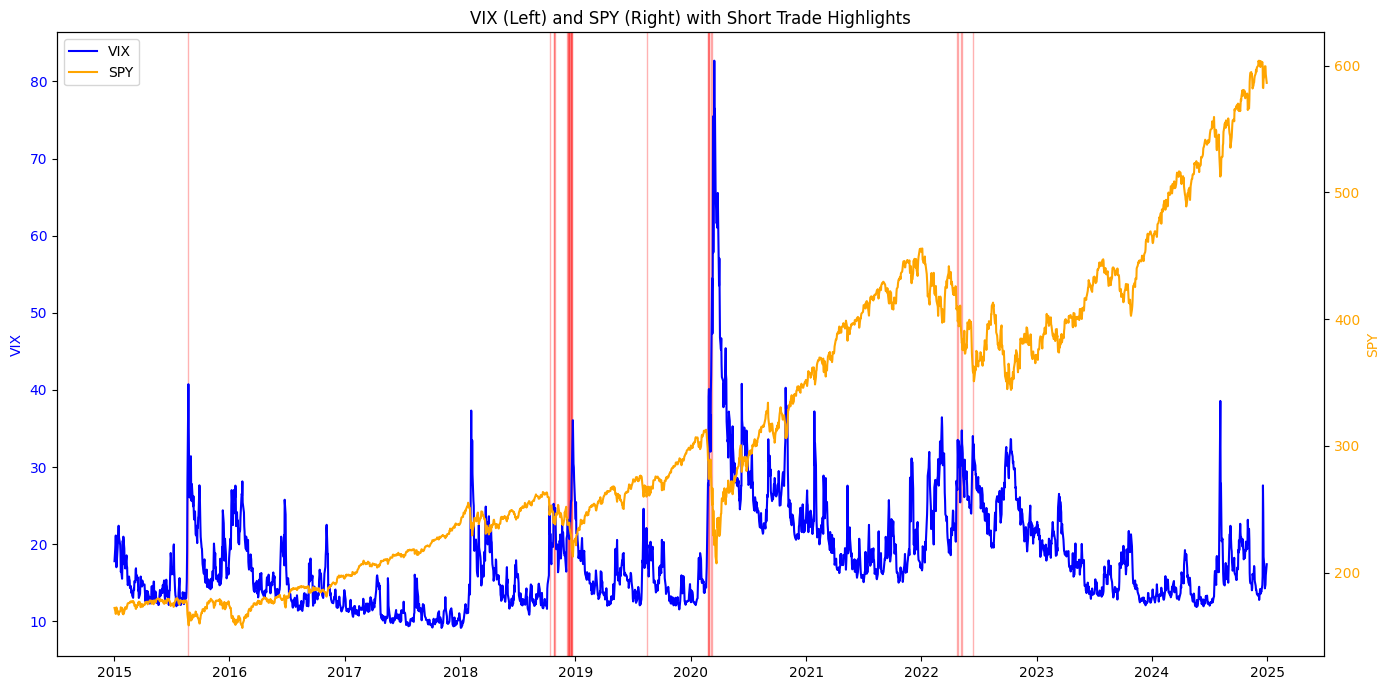

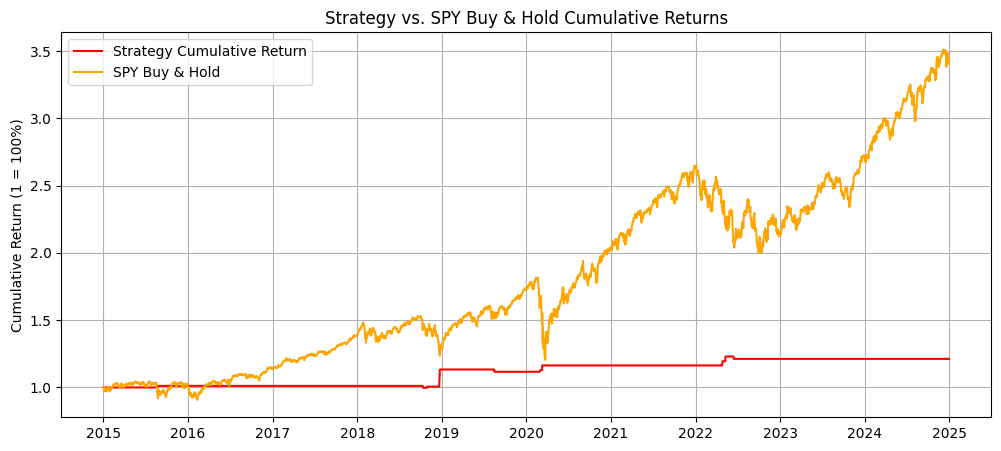

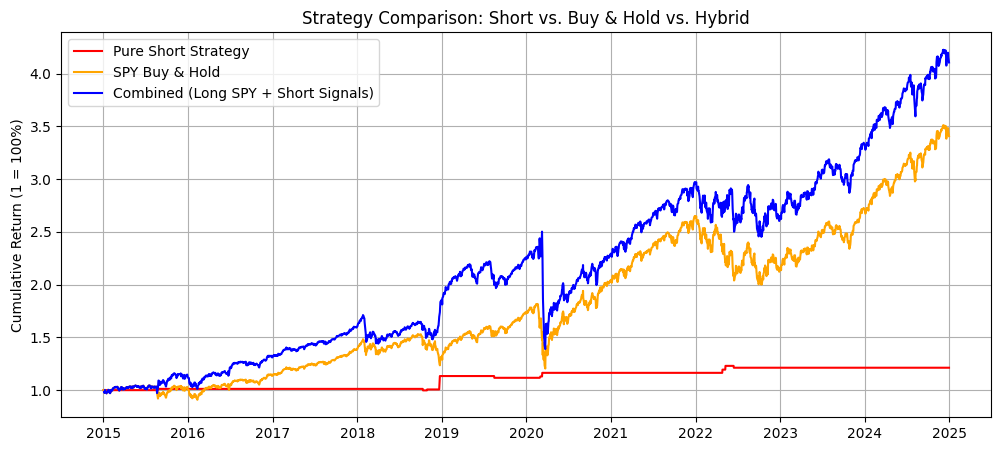

Total trades: 23
Winning trades: 7
Losing trades: 16
Win rate: 30.43%
Total strategy return: 21.24%
Pure Short Strategy Return: 21.24%
SPY Buy & Hold Return: 240.81%
Combined Strategy Return: 310.70%


In [134]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Download data
tickers = ['^VIX', 'SPY']
data = yf.download(tickers, start='2015-01-01', end='2024-12-31', auto_adjust=True)['Close']
data = data.rename(columns={'^VIX': 'VIX', 'SPY': 'SPY'})

# 2. Calculate daily % changes
data['VIX_pct'] = data['VIX'].pct_change() * 100
data['SPY_pct'] = data['SPY'].pct_change() * 100

# PARAMETERS
VIX_RISE_THRESHOLD = 20       # VIX rise % to signal fear spike
SPY_FALL_THRESHOLD = -2.5      # SPY drop % for entry
SPY_RECOVER_EXIT = 2.0       # SPY gain % to exit
VIX_DROP_EXIT = -5.0        # VIX drop % to exit
MAX_HOLD_DAYS = 13       # max holding period
STOP_LOSS = -2.0               # stop loss % from entry price

CRASH_OVERRIDE_THRESHOLD = -5.0 # Immediate short if SPY drops ≥5% in a day

# Prepare columns
data['Position'] = 0
data['Entry_Price'] = np.nan
data['Exit_Price'] = np.nan
data['Trade_Return'] = np.nan
data['In_Trade'] = False
data['Days_In_Trade'] = 0

# ===== BACKTEST LOOP WITH CRASH OVERRIDE =====
in_trade = False
entry_idx = None
entry_price = None
entry_count = 0

for i in range(1, len(data)):
    # --- ENTRY LOGIC ---
    if not in_trade:
        # Condition 1: Crash override (SPY drops ≥5% in one day)
        crash_override = data['SPY_pct'].iloc[i] <= CRASH_OVERRIDE_THRESHOLD

        # Condition 2: Standard VIX spike + SPY drop
        standard_trigger = (
            (data['VIX_pct'].iloc[i] >= VIX_RISE_THRESHOLD) and
            (data['SPY_pct'].iloc[i] <= SPY_FALL_THRESHOLD)
        )
        # Enter trade if either condition is met
        if crash_override or standard_trigger:
            # Trade executes at NEXT day's close (avoid lookahead bias)
            entry_idx = i + 1 if i + 1 < len(data) else i
            entry_price = data['SPY'].iloc[entry_idx]

            # Record trade details
            data.at[data.index[entry_idx], 'Position'] = -1  # Short position
            data.at[data.index[entry_idx], 'Entry_Price'] = entry_price
            data.at[data.index[entry_idx], 'In_Trade'] = True
            data.at[data.index[entry_idx], 'Days_In_Trade'] = 1
            in_trade = True
            entry_count += 1

            # Debug print (optional)
            trigger_type = "CRASH" if crash_override else "STANDARD"
            print(f"Entry at {data.index[entry_idx].date()} | "
                  f"Type: {trigger_type} | "
                  f"SPY: {entry_price:.2f} | "
                  f"VIX%: {data['VIX_pct'].iloc[i]:.2f} | "
                  f"SPY%: {data['SPY_pct'].iloc[i]:.2f}")

    # --- EXIT LOGIC ---
    else:
        current_idx = i
        current_price = data['SPY'].iloc[current_idx]
        days_held = data['Days_In_Trade'].iloc[current_idx - 1] + 1

        # Update trade status
        data.at[data.index[current_idx], 'In_Trade'] = True
        data.at[data.index[current_idx], 'Days_In_Trade'] = days_held
        data.at[data.index[current_idx], 'Position'] = -1  # Still short

        # Calculate current return
        ret_pct = (entry_price - current_price) / entry_price * 100

        # Exit conditions (any of these will close the trade)
        spy_recover = (current_price - entry_price) / entry_price * 100 >= SPY_RECOVER_EXIT
        vix_drop = data['VIX_pct'].iloc[current_idx] <= VIX_DROP_EXIT
        max_days = days_held >= MAX_HOLD_DAYS
        stop_loss_hit = ret_pct <= STOP_LOSS

        if spy_recover or vix_drop or max_days or stop_loss_hit:
            # Record exit
            data.at[data.index[current_idx], 'Exit_Price'] = current_price
            data.at[data.index[current_idx], 'Trade_Return'] = ret_pct / 100
            data.at[data.index[current_idx], 'Position'] = 0  # Close position
            in_trade = False

            # Debug print (optional)
            exit_reason = (
                "SPY recovery" if spy_recover else
                "VIX drop" if vix_drop else
                "Max hold days" if max_days else
                "Stop loss"
            )
            print(f"Exit at {data.index[current_idx].date()} | "
                  f"Reason: {exit_reason} | "
                  f"Return: {ret_pct:.2f}% | "
                  f"Days held: {days_held}")

print(f"Total trades triggered: {entry_count}")

# Fill forward for plotting
data['Entry_Price'].ffill(inplace=True)
data['In_Trade'].fillna(False, inplace=True)

# 4. Calculate Strategy returns
data['Strategy_Return'] = 0.0
exit_days = data['Exit_Price'].notna()
data.loc[exit_days, 'Strategy_Return'] = data.loc[exit_days, 'Trade_Return']
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod().fillna(method='ffill').fillna(1)

# Buy & Hold
data['SPY_Return'] = data['SPY'].pct_change().fillna(0)
data['Cumulative_SPY'] = (1 + data['SPY_Return']).cumprod()

#test
# Calculate daily returns for the combined strategy
data['Combined_Position'] = 1  # Default = long SPY
data.loc[data['In_Trade'], 'Combined_Position'] = -1  # Short when strategy is active

# Calculate daily returns: long SPY when position=1, short when position=-1
data['Combined_Daily_Return'] = data['Combined_Position'] * data['SPY_pct'] / 100

# Cumulative returns
data['Cumulative_Combined'] = (1 + data['Combined_Daily_Return']).cumprod()
#testend

# 5. Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# VIX on LEFT Y-axis (blue)
ax1.plot(data.index, data['VIX'], label='VIX', color='blue')
ax1.set_ylabel('VIX', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Short trade highlights
for i in range(len(data)):
    if data['Position'].iloc[i] == -1:
        ax1.axvspan(data.index[i], data.index[i], color='red', alpha=0.3)

# SPY on RIGHT Y-axis (orange)
ax2 = ax1.twinx()
ax2.plot(data.index, data['SPY'], label='SPY', color='orange')
ax2.set_ylabel('SPY', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Merge both legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('VIX (Left) and SPY (Right) with Short Trade Highlights')
fig.tight_layout()
plt.show()


# Cumulative returns
plt.figure(figsize=(12, 5))
plt.plot(data['Cumulative_Strategy'], label='Strategy Cumulative Return', color='red')
plt.plot(data['Cumulative_SPY'], label='SPY Buy & Hold', color='orange')
plt.title('Strategy vs. SPY Buy & Hold Cumulative Returns')
plt.ylabel('Cumulative Return (1 = 100%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(data['Cumulative_Strategy'], label='Pure Short Strategy', color='red')
plt.plot(data['Cumulative_SPY'], label='SPY Buy & Hold', color='orange')
plt.plot(data['Cumulative_Combined'], label='Combined (Long SPY + Short Signals)', color='blue')
plt.title('Strategy Comparison: Short vs. Buy & Hold vs. Hybrid')
plt.ylabel('Cumulative Return (1 = 100%)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Performance Summary
total_trades = data['Trade_Return'].count()
winning_trades = (data['Trade_Return'] > 0).sum()
losing_trades = (data['Trade_Return'] <= 0).sum()
win_rate = winning_trades / total_trades if total_trades > 0 else 0
total_return = data['Cumulative_Strategy'].iloc[-1] - 1

print(f"Total trades: {total_trades}")
print(f"Winning trades: {winning_trades}")
print(f"Losing trades: {losing_trades}")
print(f"Win rate: {win_rate:.2%}")
print(f"Total strategy return: {total_return:.2%}")

combined_return = data['Cumulative_Combined'].iloc[-1] - 1
print(f"Pure Short Strategy Return: {total_return:.2%}")
print(f"SPY Buy & Hold Return: {data['Cumulative_SPY'].iloc[-1] - 1:.2%}")
print(f"Combined Strategy Return: {combined_return:.2%}")
